# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=30,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_12-44-19/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4949 | MulticlassF1Score=0.1697
Batch-30 : CrossEntropyLoss=2.4492 | MulticlassF1Score=0.2325
Batch-45 : CrossEntropyLoss=2.4196 | MulticlassF1Score=0.3177
Batch-60 : CrossEntropyLoss=2.3874 | MulticlassF1Score=0.3732
Batch-75 : CrossEntropyLoss=2.3758 | MulticlassF1Score=0.4076
Batch-90 : CrossEntropyLoss=2.3885 | MulticlassF1Score=0.4378
Batch-105: CrossEntropyLoss=2.3692 | MulticlassF1Score=0.4614
Batch-120: CrossEntropyLoss=2.3536 | MulticlassF1Score=0.4845
Batch-135: CrossEntropyLoss=2.3470 | MulticlassF1Score=0.5049
Batch-150: CrossEntropyLoss=2.3421 | MulticlassF1Score=0.5218
Batch-165: CrossEntropyLoss=2.3470 | MulticlassF1Score=0.5344
Batch-180: CrossEntropyLoss=2.3605 | MulticlassF1Score=0.5461
Batch-195: CrossEntropyLoss=2.3521 | MulticlassF1Score=0.5560
Batch-210: CrossEntropyLoss=2.3400 | MulticlassF1Score=0.5651
Batch-225: CrossEntropyLoss=2.3384 | MulticlassF1Score=0.5751
Batch-226: CrossEntropyLoss=2.3522 | MulticlassF1Score=0.5755

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3275 | MulticlassF1Score=0.7158
Batch-30 : CrossEntropyLoss=2.3315 | MulticlassF1Score=0.7209
Batch-45 : CrossEntropyLoss=2.3371 | MulticlassF1Score=0.7193
Batch-60 : CrossEntropyLoss=2.3443 | MulticlassF1Score=0.7197
Batch-63 : CrossEntropyLoss=2.3465 | MulticlassF1Score=0.7193

Training   : Mean CrossEntropyLoss = 2.3940 | Mean MulticlassF1Score = 0.4326
Validation : Mean CrossEntropyLoss = 2.3357 | Mean MulticlassF1Score = 0.7171

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3513 | MulticlassF1Score=0.7313
Batch-30 : CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7344
Batch-45 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7467
Batch-60 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7545
Batch-75 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7612
Batch-90 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7645
Batch-105: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7673
Batch-120: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7701
Batch-135: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7725
Batch-150: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7741
Batch-165: CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7744
Batch-180: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.7756
Batch-195: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7769
Batch-210: CrossEntropyLoss=2.3141 | MulticlassF1Score=0.7782
Batch-225: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7793
Batch-226: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7794

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.7980
Batch-30 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7988
Batch-45 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7993
Batch-60 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8009
Batch-63 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8014

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3173 | Mean MulticlassF1Score = 0.7620
Validation : Mean CrossEntropyLoss = 2.3102 | Mean MulticlassF1Score = 0.7968

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8104
Batch-30 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8098
Batch-45 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8144
Batch-60 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8128
Batch-75 : CrossEntropyLoss=2.3222 | MulticlassF1Score=0.8126
Batch-90 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8133
Batch-105: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8122
Batch-120: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8124
Batch-135: CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8124
Batch-150: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8120
Batch-165: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8119
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8117
Batch-195: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8120
Batch-210: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8125
Batch-225: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8128
Batch-226: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.8127

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.8112
Batch-30 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.8122
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8123
Batch-60 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8140
Batch-63 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8146

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3063 | Mean MulticlassF1Score = 0.8119
Validation : Mean CrossEntropyLoss = 2.3053 | Mean MulticlassF1Score = 0.8147

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8331
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8333
Batch-60 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8340
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8342
Batch-90 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8331
Batch-105: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8333
Batch-120: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8341
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8346
Batch-150: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8343
Batch-165: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8341
Batch-180: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8343
Batch-195: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8349
Batch-210: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8347
Batch-225: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8352
Batch-226: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8356
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8361
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8349
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8357
Batch-63 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8342
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8359

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8382
Batch-30 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8367
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8384
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8372
Batch-75 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8395
Batch-90 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8393
Batch-105: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8401
Batch-120: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8392
Batch-135: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8386
Batch-150: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8395
Batch-165: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8393
Batch-180: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8389
Batch-195: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8390
Batch-210: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8395
Batch-225: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8387
Batch-226: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8388
Batch-30 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8319
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8359
Batch-60 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8369
Batch-63 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8371

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8389
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8375

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8397
Batch-30 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8395
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8416
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8427
Batch-75 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8425
Batch-90 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8425
Batch-105: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8421
Batch-120: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8412
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8408
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8403
Batch-165: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8405
Batch-180: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8408
Batch-195: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8405
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8407
Batch-225: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8408
Batch-226: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8418
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8381
Batch-45 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8390
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8383
Batch-63 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8384

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8408
Validation : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8411

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8395
Batch-30 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8394
Batch-45 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8394
Batch-60 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8397
Batch-75 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8402
Batch-90 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8410
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8417
Batch-120: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8422
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8420
Batch-150: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8422
Batch-165: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8422
Batch-180: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8426
Batch-195: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8426
Batch-210: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8438
Batch-225: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8456
Batch-226: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8731
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8734
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8754
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8755
Batch-63 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8754

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2956 | Mean MulticlassF1Score = 0.8414
Validation : Mean CrossEntropyLoss = 2.2875 | Mean MulticlassF1Score = 0.8742

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8776
Batch-30 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8787
Batch-45 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8813
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8817
Batch-75 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8826
Batch-90 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8827
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8832
Batch-120: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8837
Batch-135: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8836
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8846
Batch-165: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8853
Batch-180: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8852
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8853
Batch-210: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8859
Batch-225: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8859
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8859

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8838
Batch-45 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8847
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8847
Batch-63 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8846

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8828
Validation : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8858

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8926
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8914
Batch-75 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8915
Batch-90 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8917
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8910
Batch-120: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8908
Batch-135: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8910
Batch-150: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8906
Batch-165: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8903
Batch-180: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8897
Batch-195: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8899
Batch-210: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8902
Batch-225: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8904
Batch-226: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8903

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8854
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8873
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8853
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8853

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8911
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8853

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8930
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8937
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8947
Batch-75 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8932
Batch-90 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8935
Batch-120: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8931
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8929
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8931
Batch-165: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8930
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8933
Batch-195: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8933
Batch-210: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8934
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8931

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8852
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8871
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8935
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8861

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8919
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8956
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8964
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8960
Batch-75 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8962
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8958
Batch-105: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8955
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8954
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8955
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8948
Batch-180: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8951
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8947
Batch-210: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8948
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8949
Batch-226: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8948

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8885
Batch-45 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8889
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8878
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8881

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8954
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8878

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9020
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9006
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8990
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.8982
Batch-75 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8979
Batch-90 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8989
Batch-105: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8985
Batch-135: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8987
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8990
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8988
Batch-180: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8991
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8990
Batch-210: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8995
Batch-225: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8996
Batch-226: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8996

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8951
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8948
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8910
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8913

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8991
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8931

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9030
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9029
Batch-75 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9026
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9028
Batch-105: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9031
Batch-120: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9026
Batch-135: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9026
Batch-150: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9025
Batch-165: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.9021
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9020
Batch-195: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9022
Batch-210: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9015
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9016
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9016

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8897
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8904
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8916
Batch-63 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8918

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9028
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8908

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9021
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9045
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9043
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9053
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9055
Batch-90 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9055
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9042
Batch-135: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9043
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9044
Batch-165: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9043
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9041
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9036
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9033
Batch-226: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9033

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8950
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8929
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8928
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8926

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9046
Validation : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8933

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9056
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9055
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9057
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9051
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9051
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9045
Batch-135: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9044
Batch-150: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9043
Batch-165: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9042
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9042
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9043
Batch-225: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9044
Batch-226: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9044

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8926
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8931
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8932

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9047
Validation : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8937

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9054
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9074
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9064
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9066
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9065
Batch-90 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9060
Batch-105: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9059
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9058
Batch-135: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9058
Batch-150: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9058
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9058
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9057
Batch-195: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9058
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9055
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9057
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9057

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8939
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8932
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8932
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8939
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.8937

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2768 | Mean MulticlassF1Score = 0.9060
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8928

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9053
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9046
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9056
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9055
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9059
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9055
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9060
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9072
Batch-135: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9091
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9115
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9133
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9149
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9162
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9173
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9184
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9184

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9093
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9173

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9354
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9343
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9347
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9353
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9361
Batch-105: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9353
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9349
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9346
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9348
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9349
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9349
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9347
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9347
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9348
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9348

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9204

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9341
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9361
Batch-105: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9360
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9362
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9363
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9358
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9358
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9360
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9203

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9354
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9368
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9368
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9369
Batch-195: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9371
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9368
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9212

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9368
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9229

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9372
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9368
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9370
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9369
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9374
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9177
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9369
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9190

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9375
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9387
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9386
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9382
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9381
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9383
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9378
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9214

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9375
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9375
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9381
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9383
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9388
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9207

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9399
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9397
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9393
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9232

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9380
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9391
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9392
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9391
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9395
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9220

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9414
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9401
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9401
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9400
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9233

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9371
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9386
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9392
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9398
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9230

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9400
Batch-210: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9400
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9400
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9234

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9411
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9407
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9407
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9405
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9243

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9409
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9411
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9248

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9422
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9420
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9417

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9418

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9600
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9598
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9599
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9601
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9601
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9603
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9604
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9602
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9605
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9604
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9603
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9602
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9601
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9602
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9602

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9419
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9419

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9601
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9411

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9610
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9596
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9602
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9604
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9609
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9612
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9608
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9611
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9614
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9617
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9614
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9412
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9415

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9609
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9426

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9617
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9614
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9618
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9617
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9616
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9618
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9619
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9616
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9618
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9616
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9616

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9617
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9452

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9598
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9598
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9610
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9610
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9616
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9618
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9620
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9625
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9631
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9629
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9630
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9630
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9631
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9631

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9467

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9649
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9656
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9658
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9661

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9466

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9480

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9494

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9490
Patience = 1/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9731
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9515
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9465

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9722
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9493

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9476

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9473
Patience = 2/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9475
Patience = 3/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9474

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9486

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9520
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9502

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9520
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9523
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9511
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9502
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9503

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9520

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9504
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9502

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9502

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9717
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9726
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9723
Batch-120: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9726
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9726
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9722
Batch-180: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9721
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9513
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9513
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9511

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9723
Validation : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9499

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2562
Best CrossEntropyLoss training    : 2.2627
Best MulticlassF1Score validation : 0.9723
Best MulticlassF1Score validation : 0.9499
Training duration                 : 2.4396 minutes.
Training date                     : 2022-10-19 09:11:23.621536+08:00


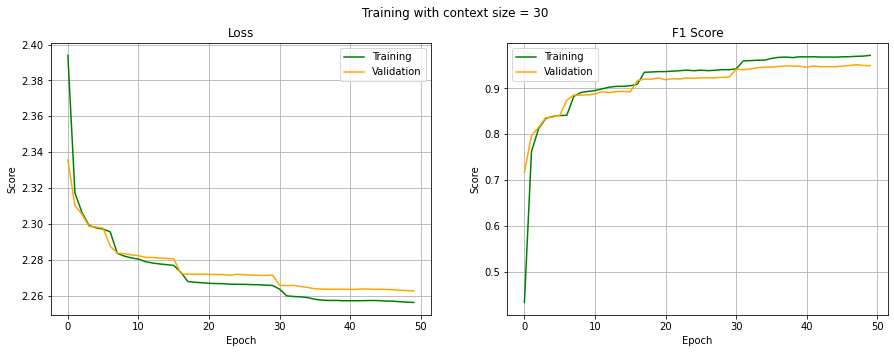

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9511, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9511, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

## Heatmap

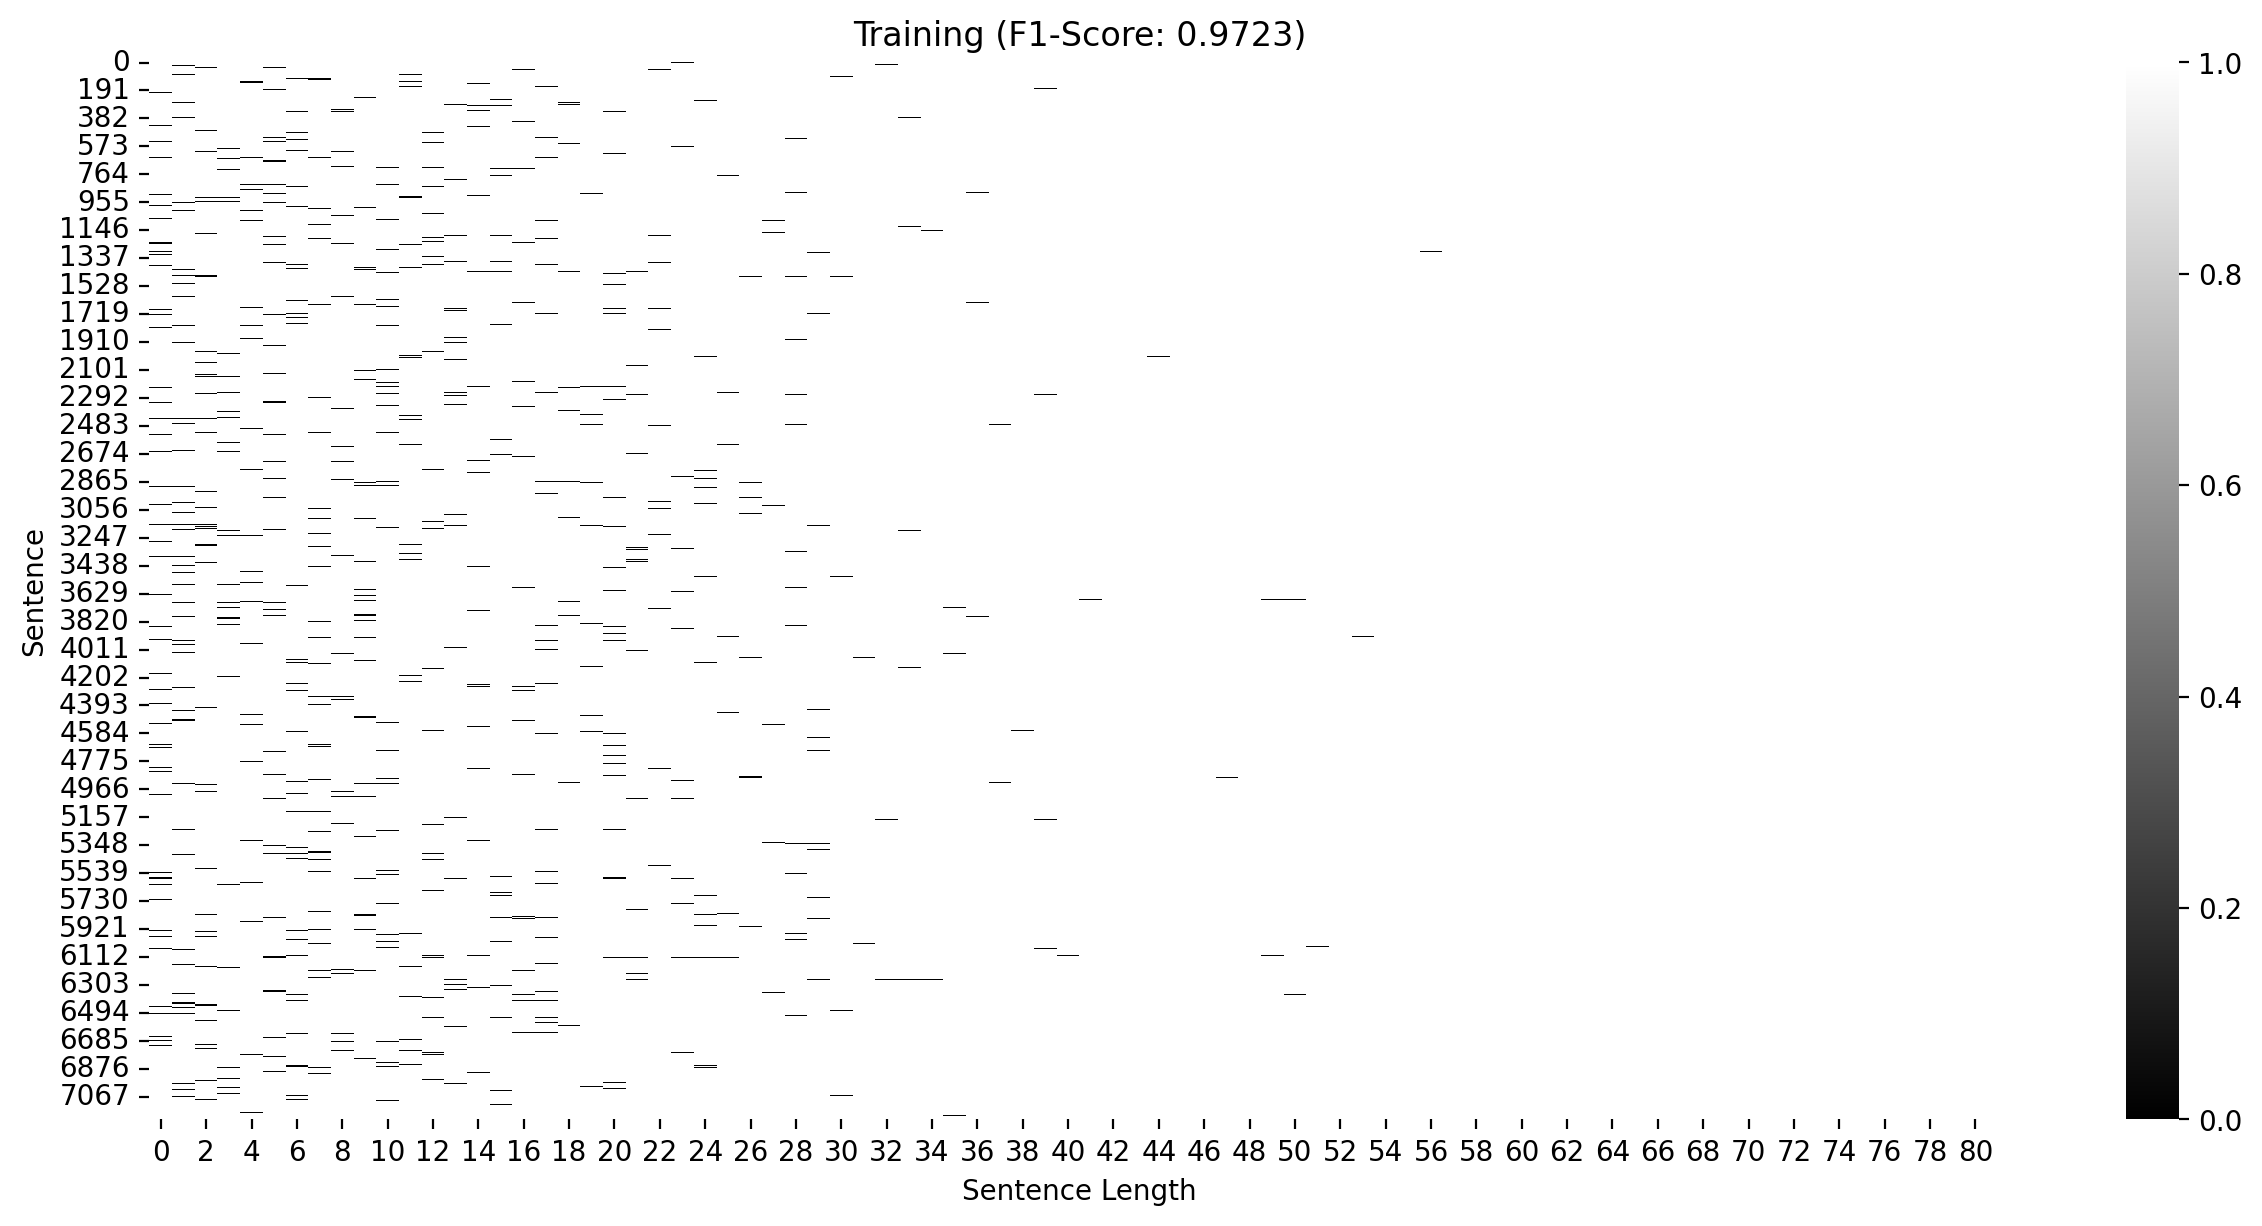

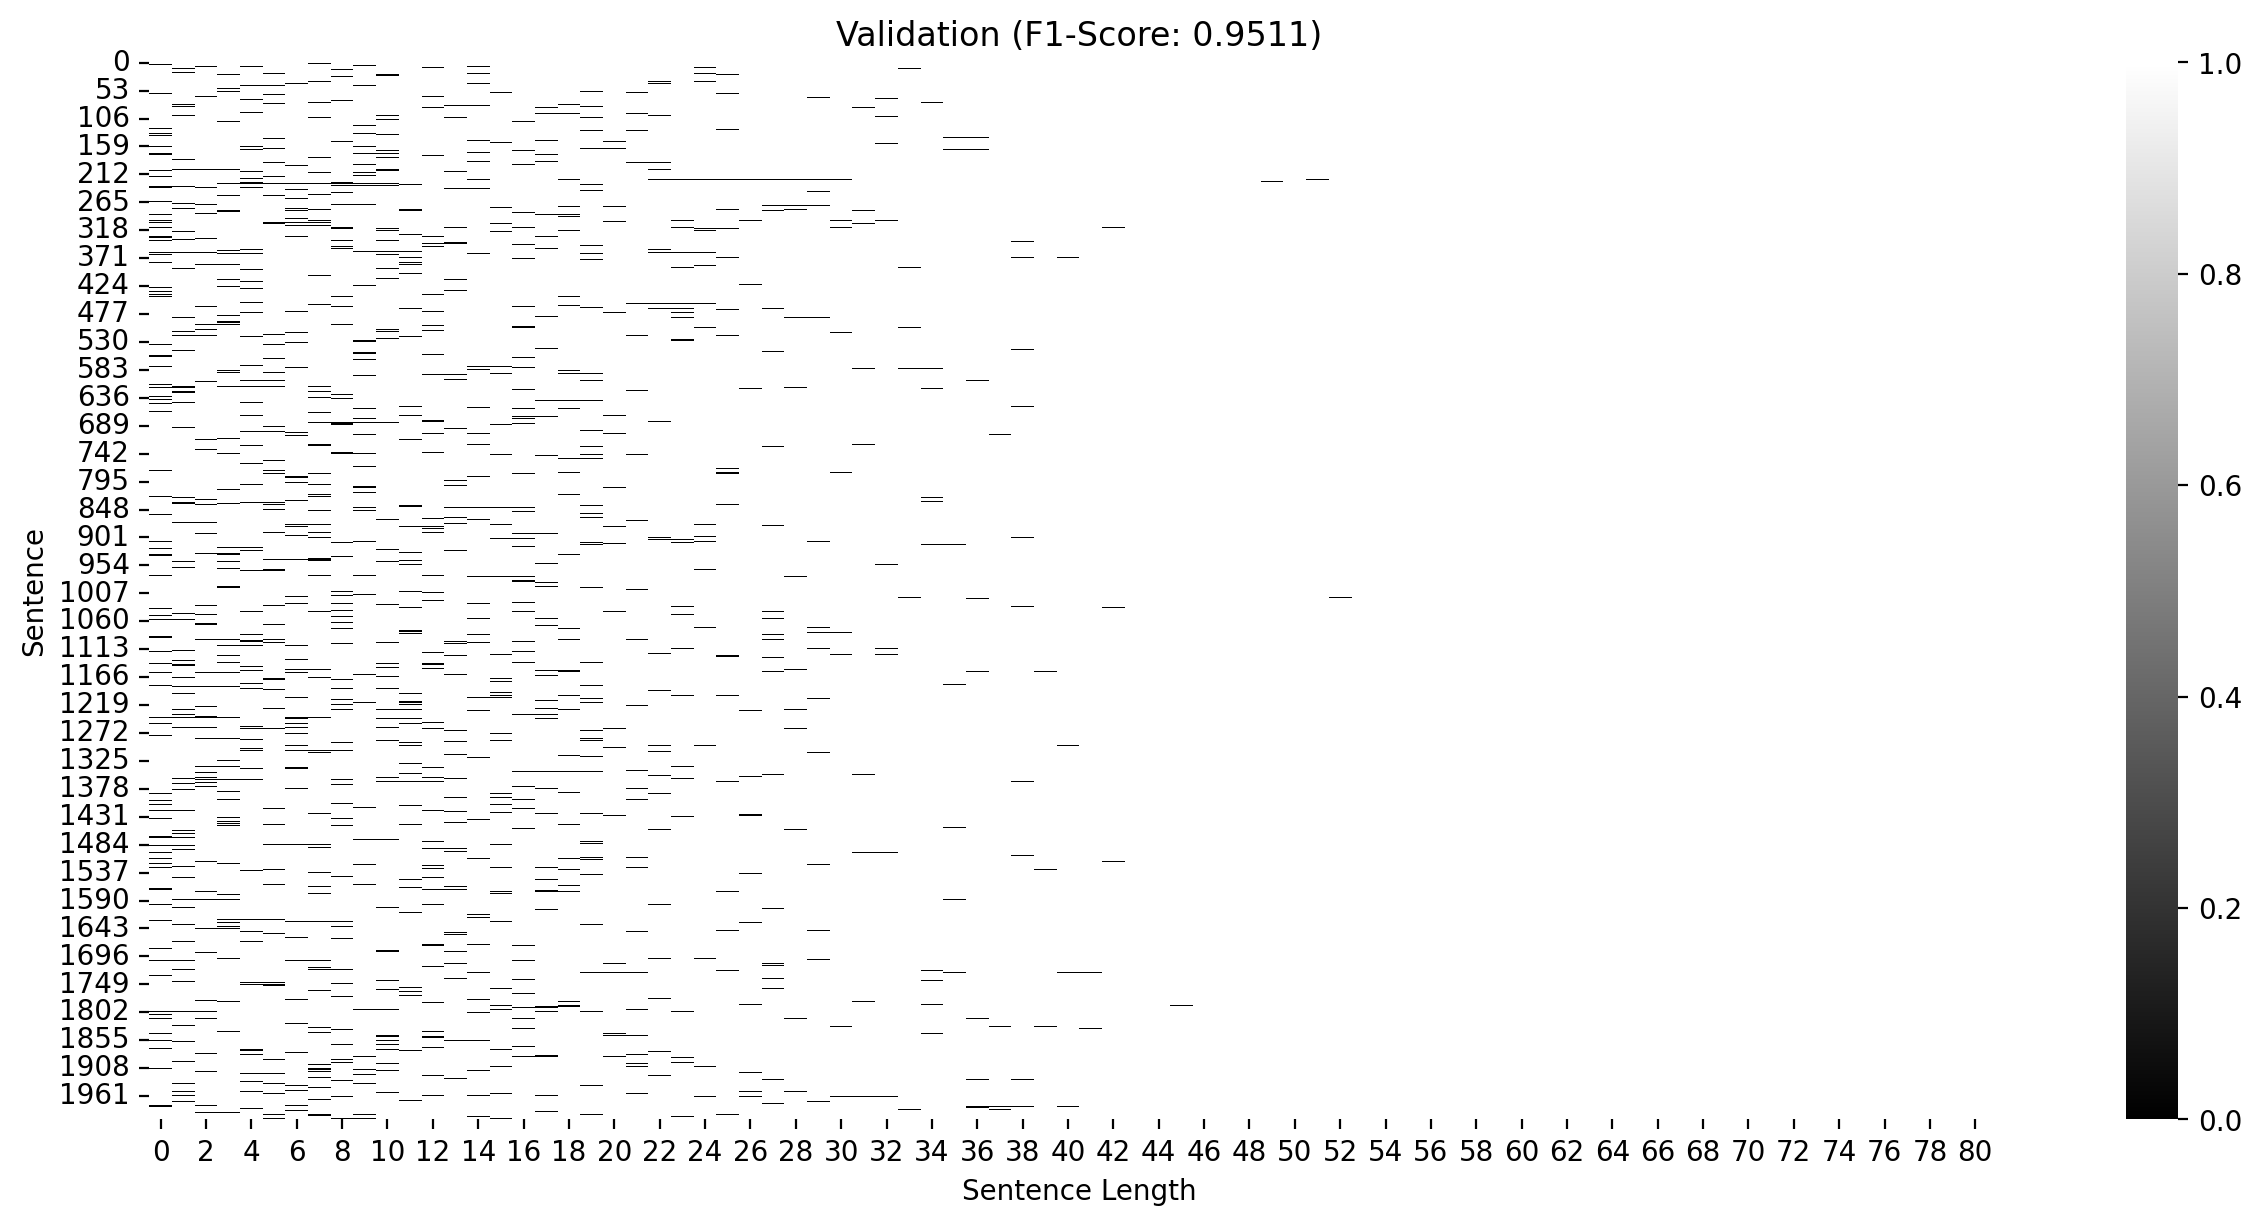

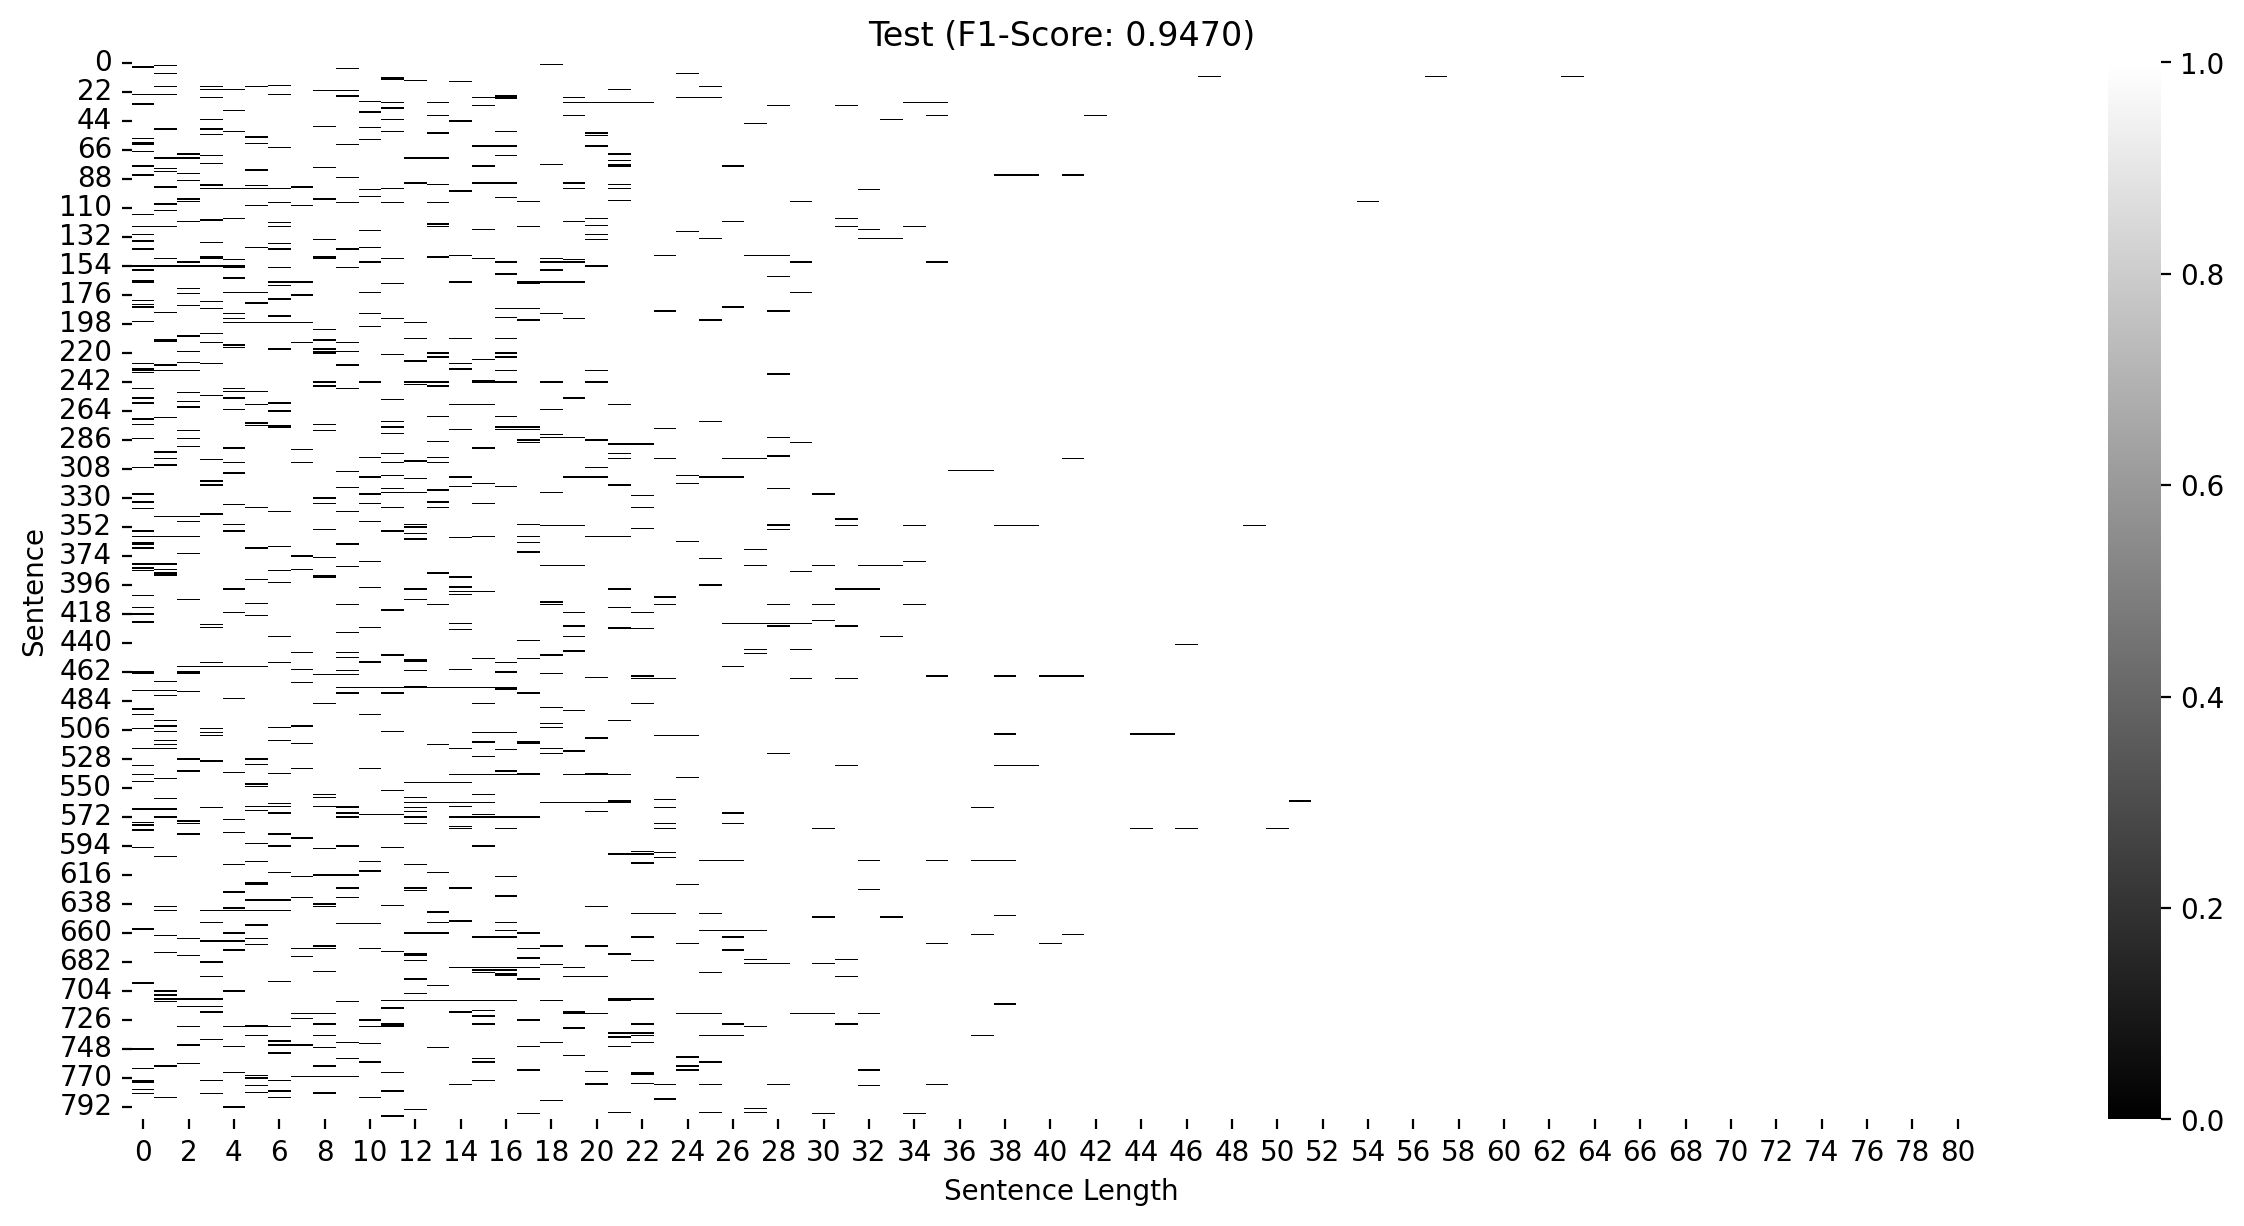

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


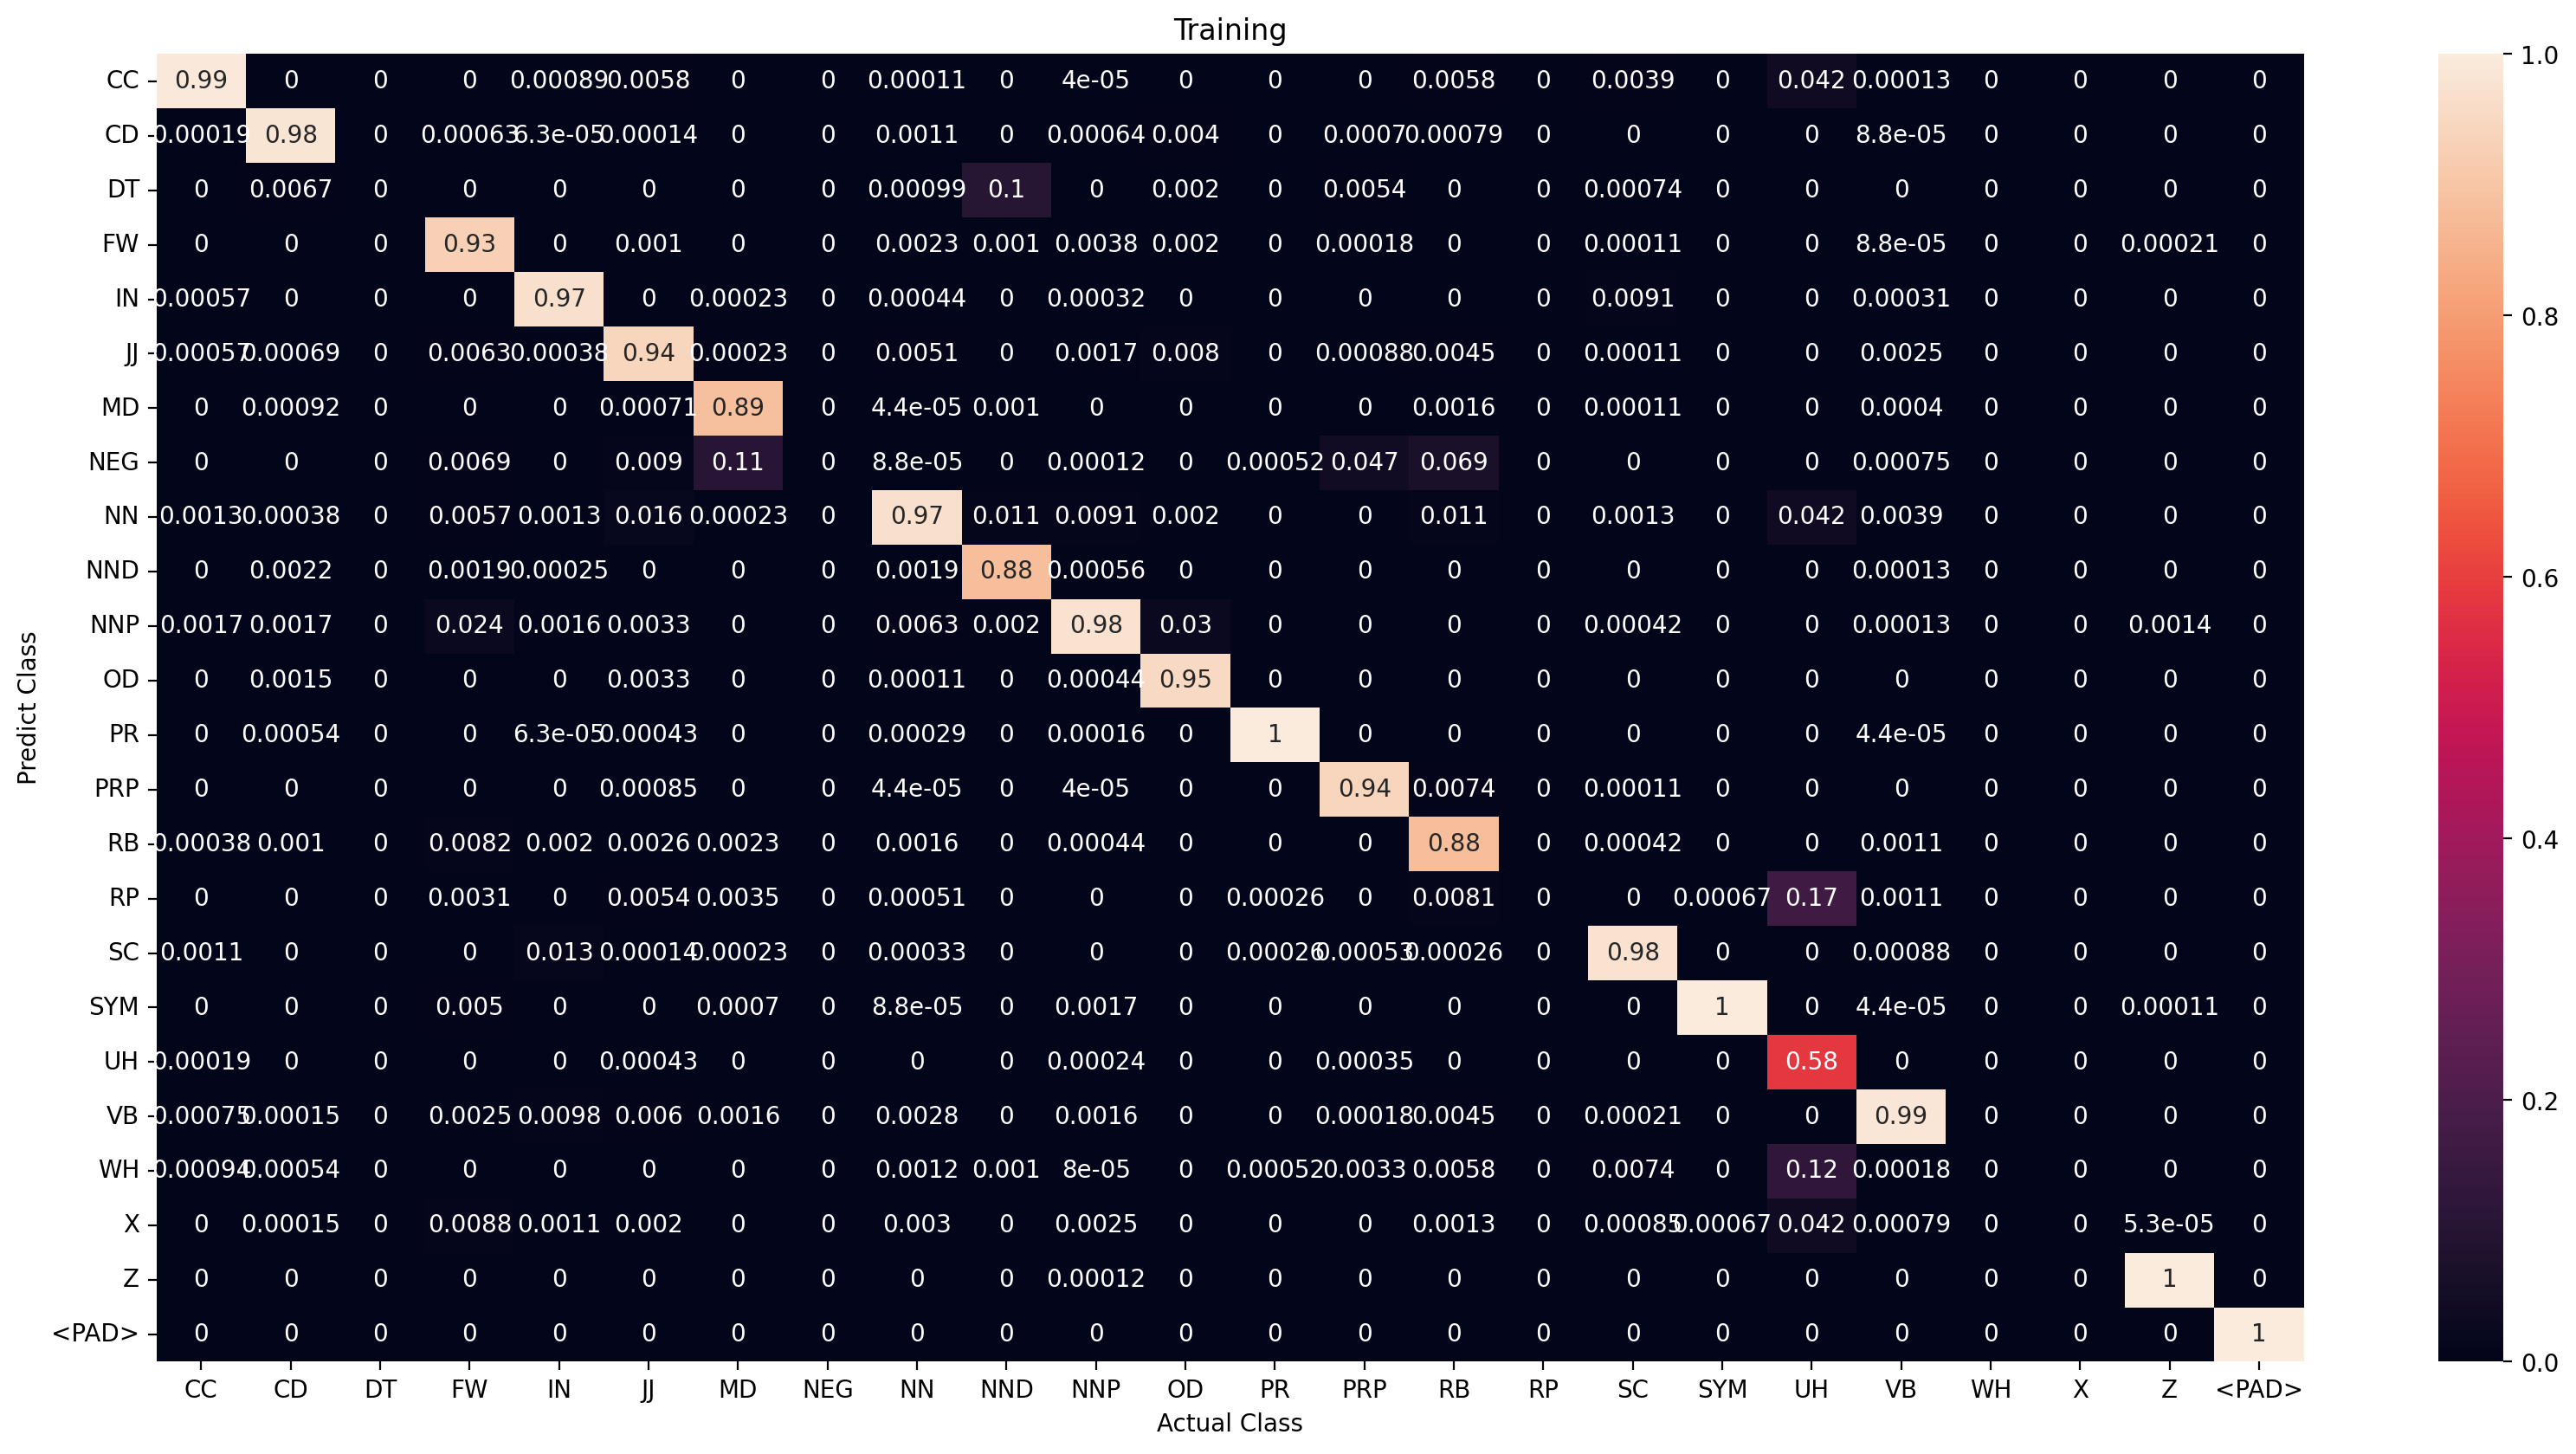

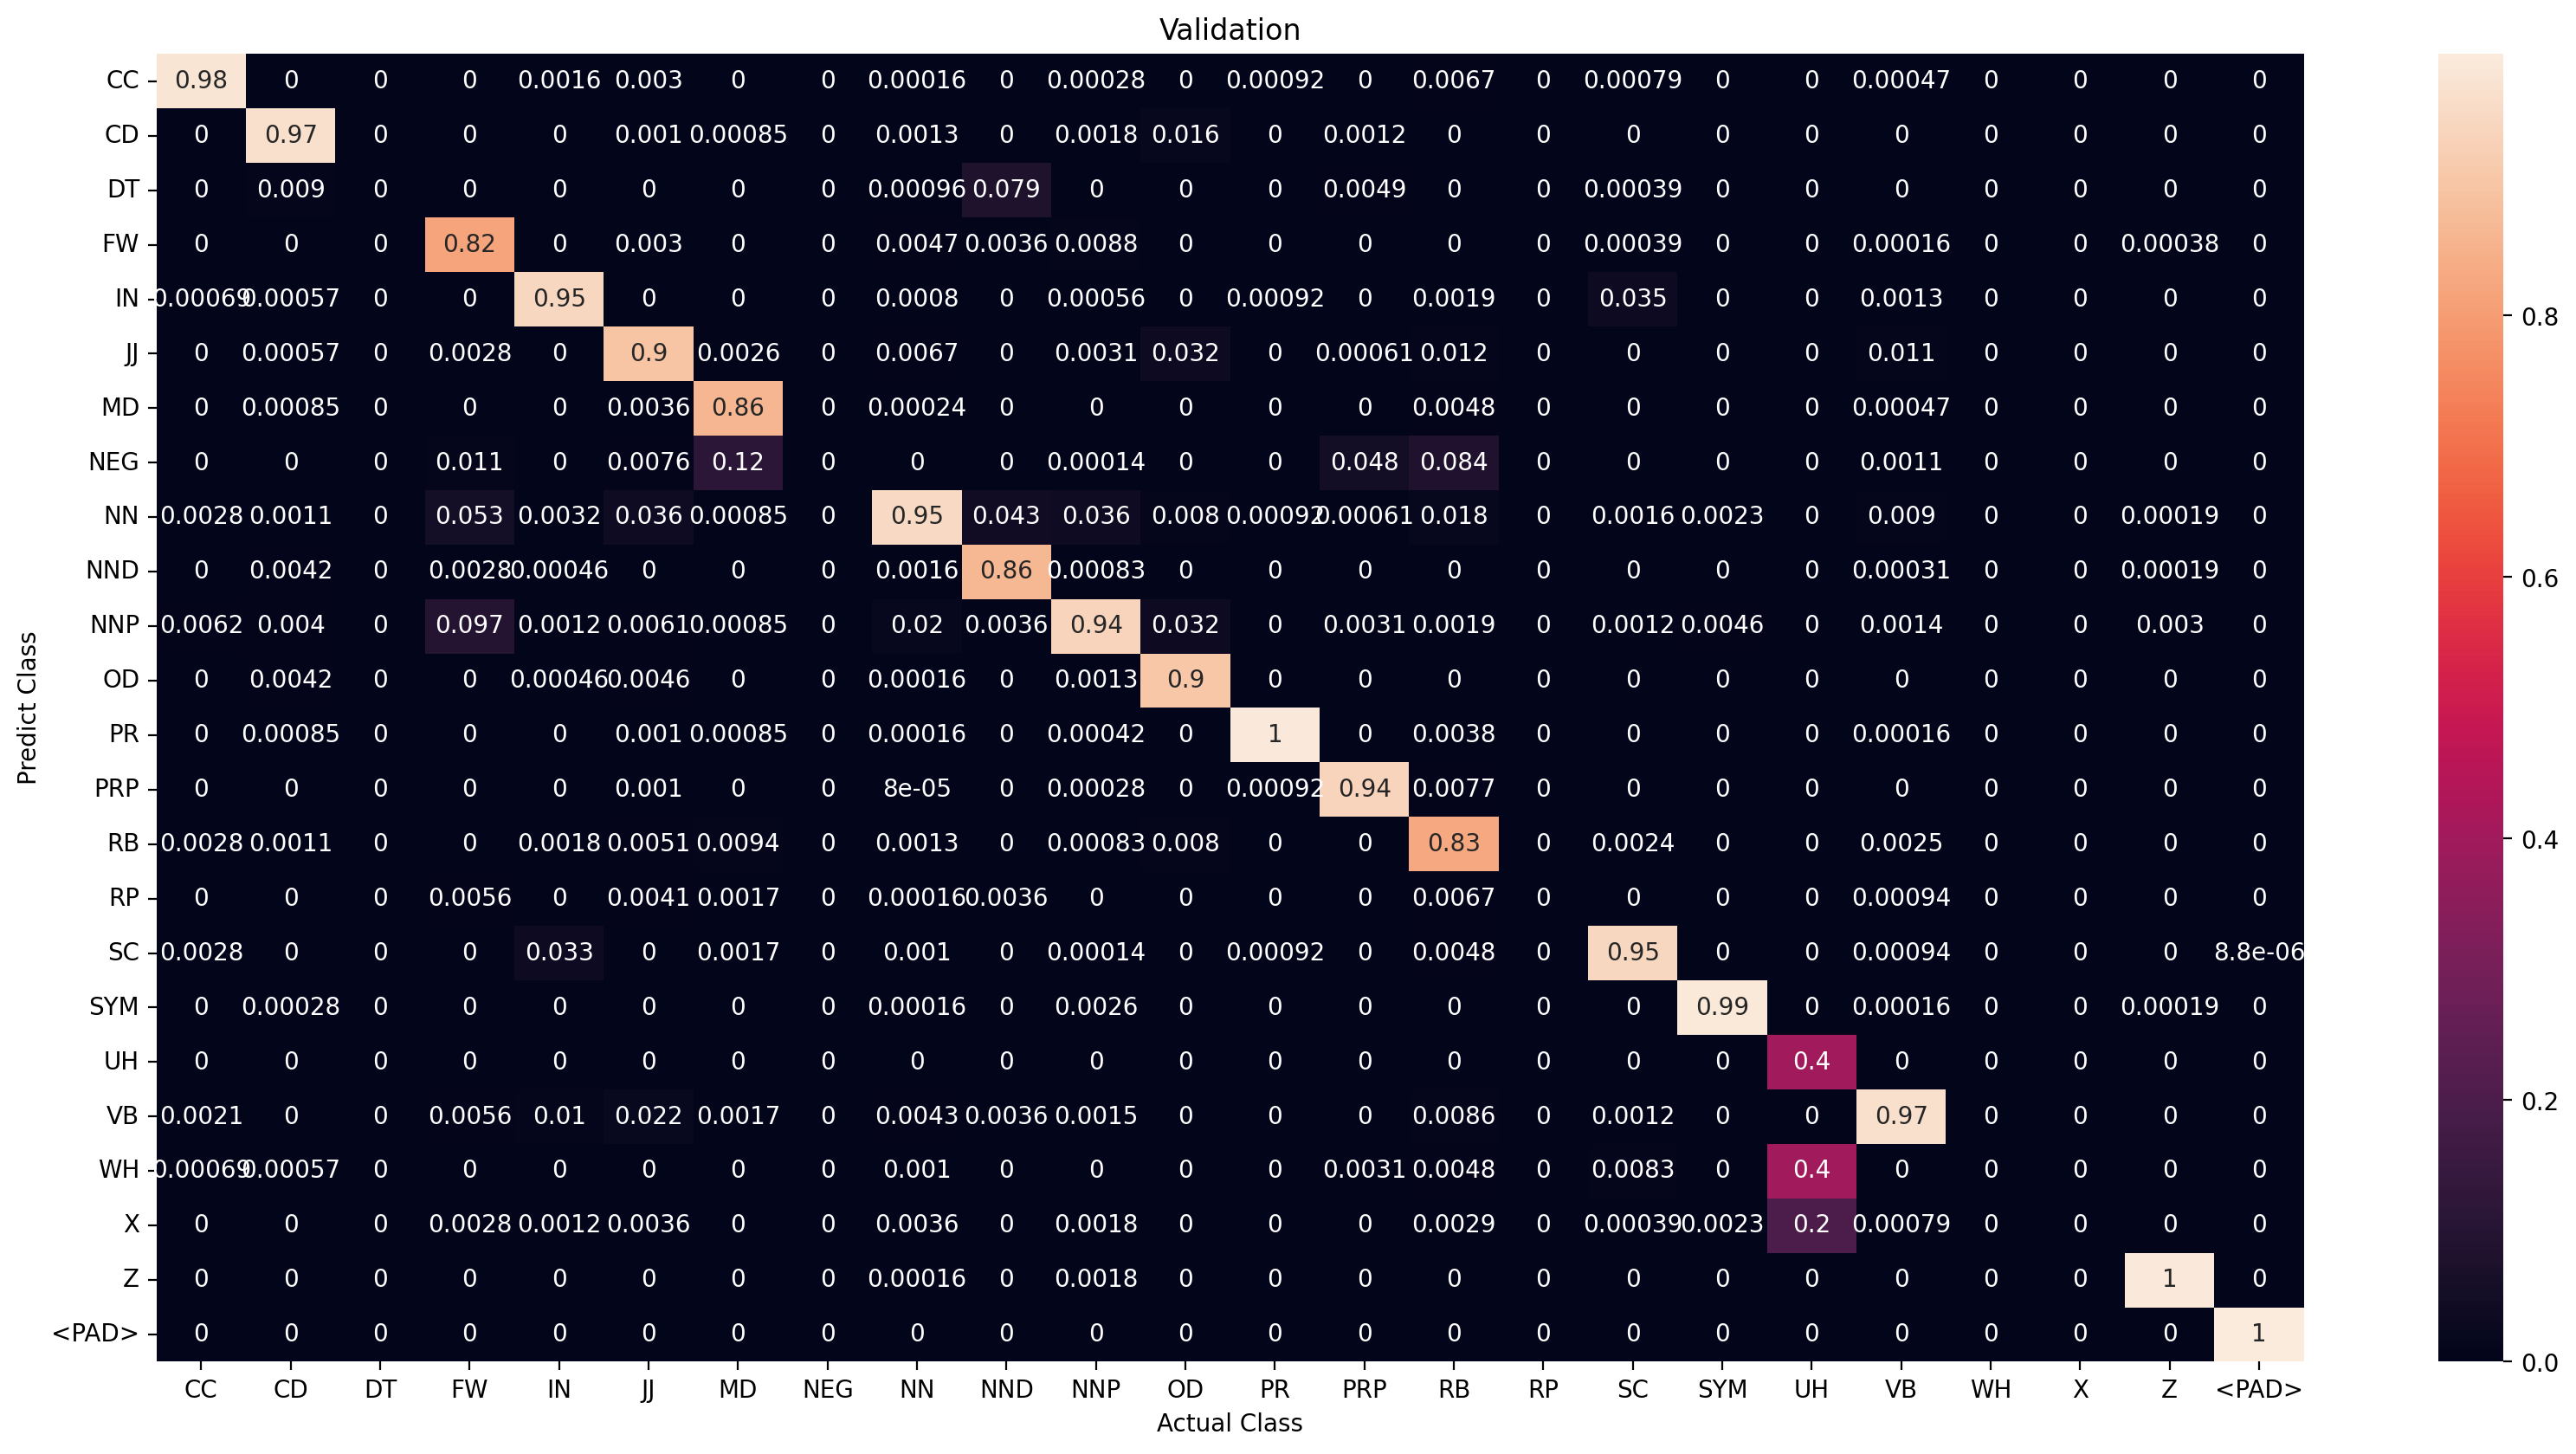

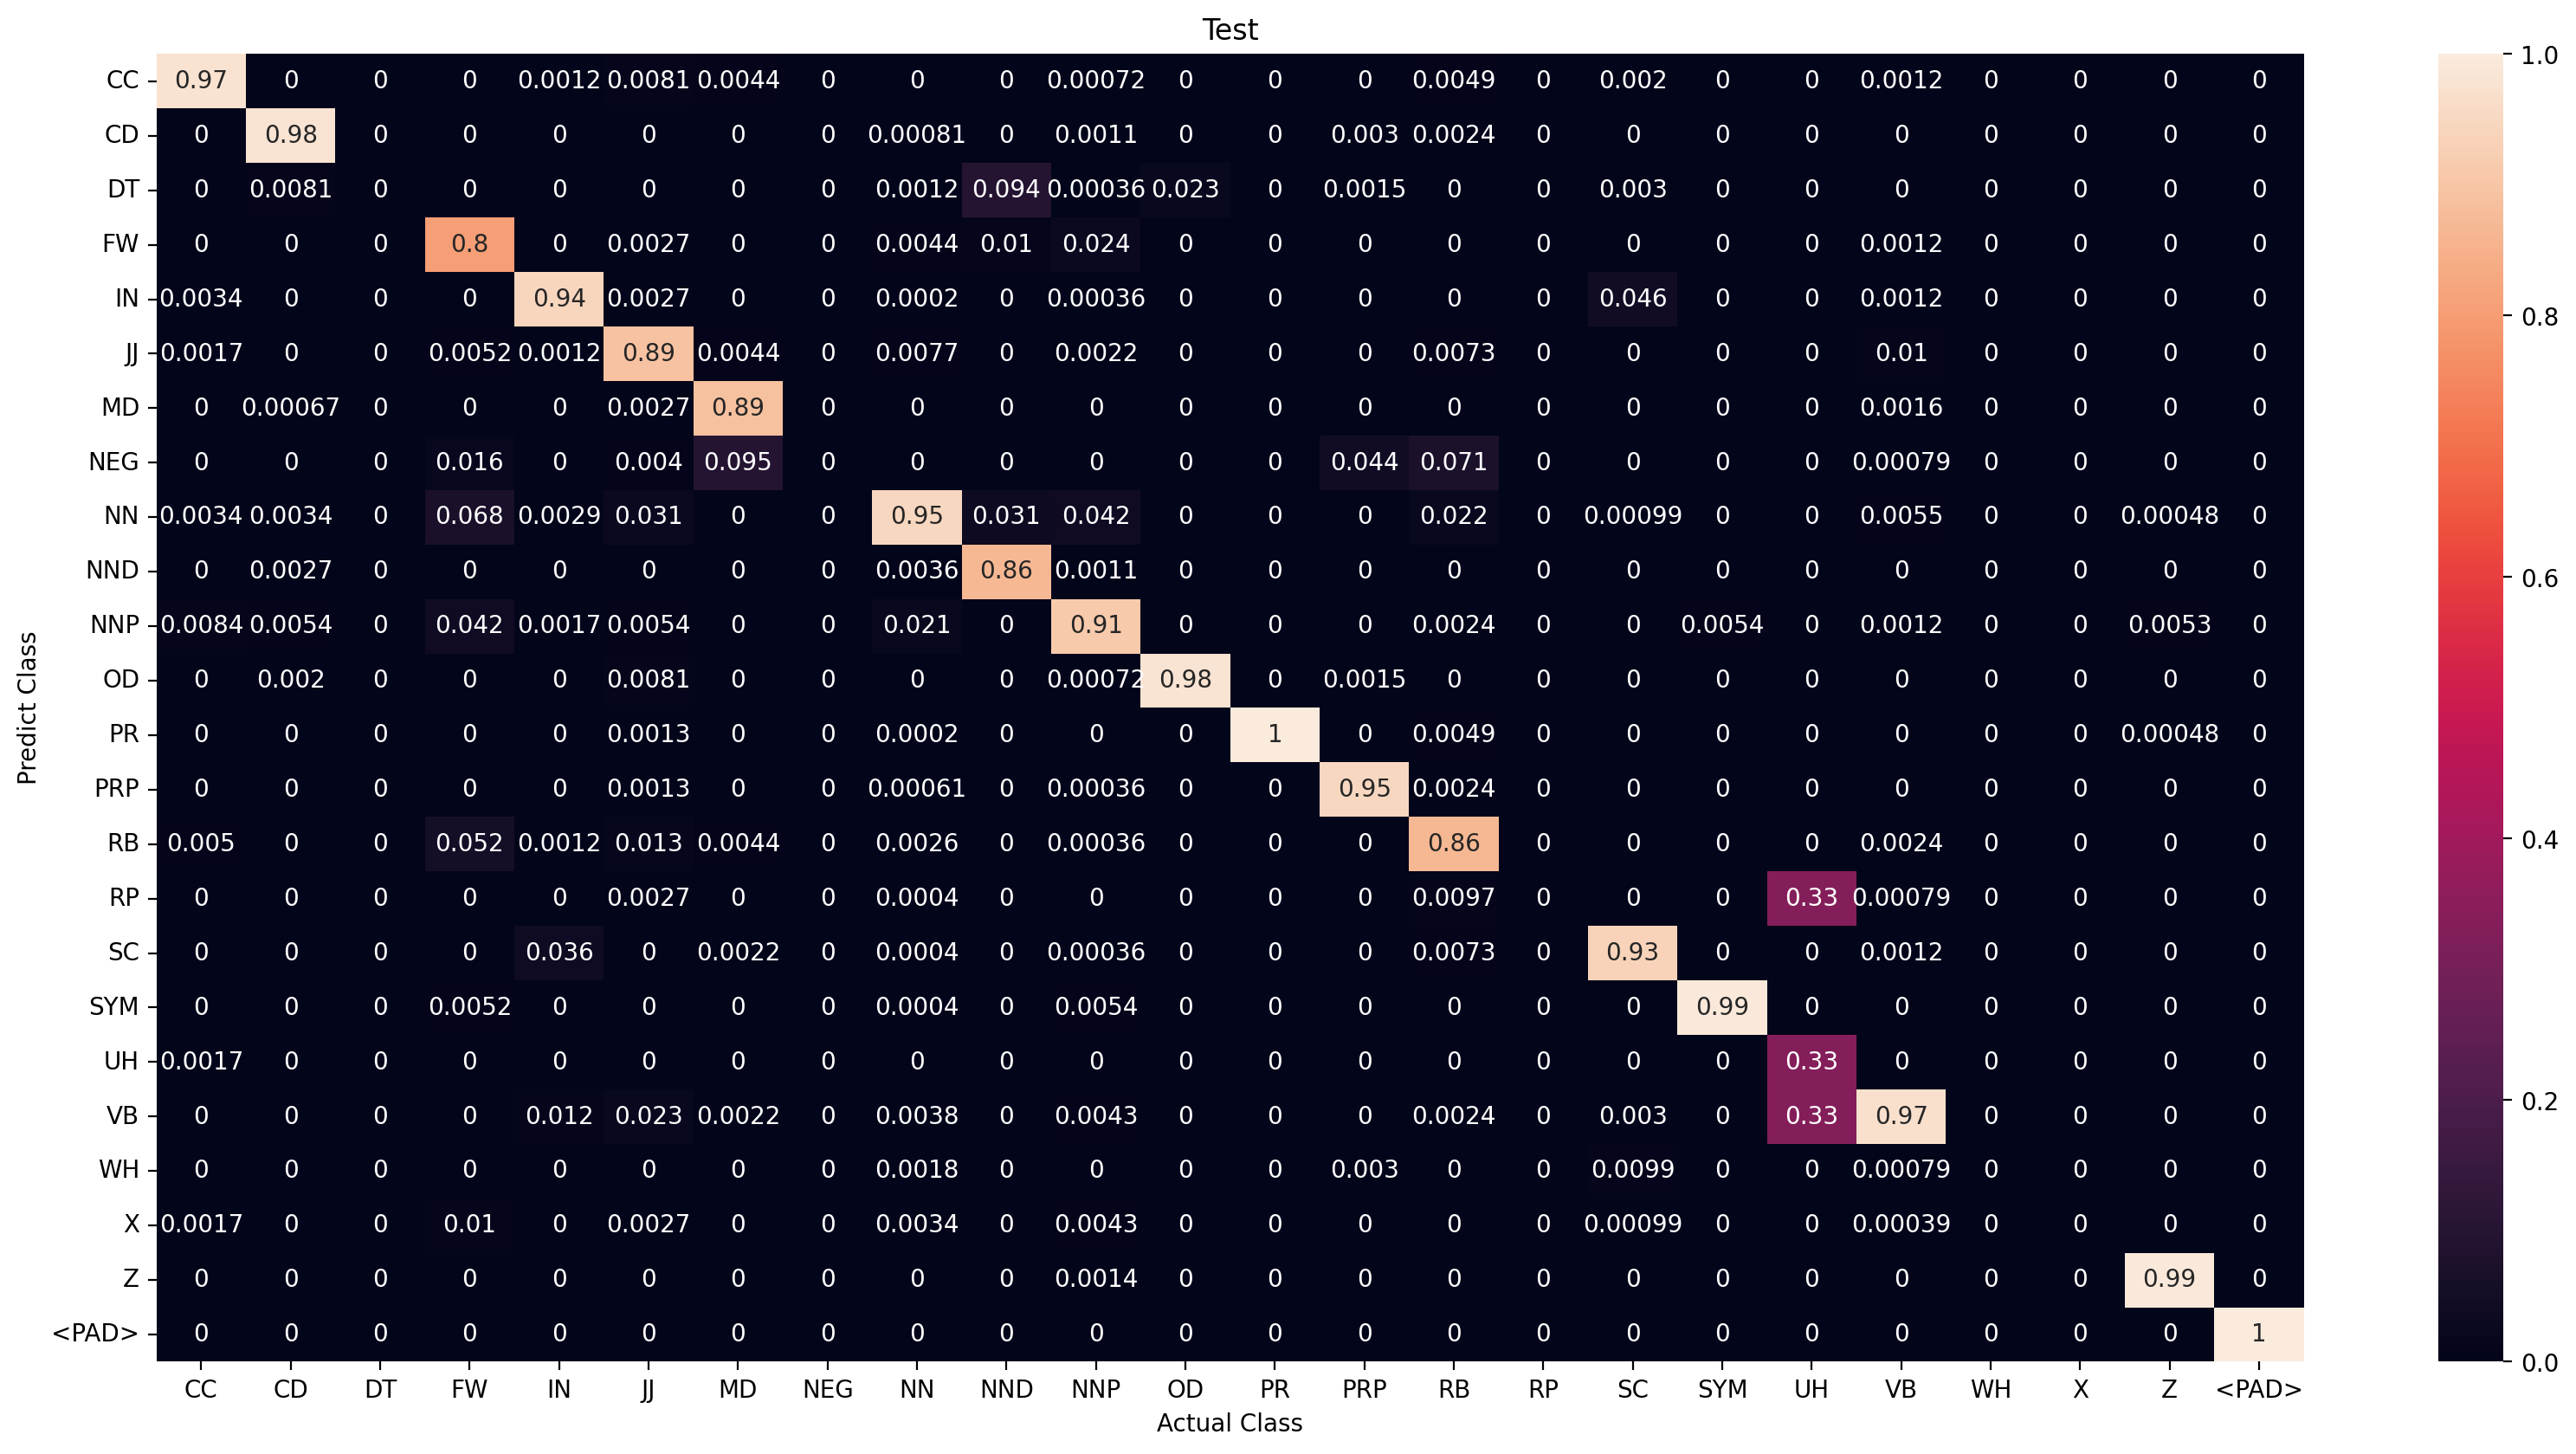

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5267       | CC    : 124      |
| CD    : 12882  | CD    : 12800      | CD    : 82       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1472       | FW    : 218      |
| IN    : 15403  | IN    : 15278      | IN    : 125      |
| JJ    : 7018   | JJ    : 6631       | JJ    : 387      |
| MD    : 3810   | MD    : 3774       | MD    : 36       |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44190      | NN    : 538      |
| NND   : 1019   | NND   : 881        | NND   : 138      |
| NNP   : 24885  | NNP   : 24429      | NNP   : 456      |
| OD    : 534    | OD    : 475        | OD    : 59       |
| PR    : 3842   | PR    : 3813       | PR    : 29       |
| PRP   : 5405   | PRP   : 5367       | PRP   : 38       |
| RB    : 3553   | RB    : 3351       | RB    : 202      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11133
Wrong prediction            : 675
Percentage correct oov pred : 94.28353658536585

Validation
Number OOV token            : 3395
Correct prediction          : 3023
Wrong prediction            : 372
Percentage correct oov pred : 89.04270986745213

Test
Number OOV token            : 1359
Correct prediction          : 1212
Wrong prediction            : 147
Percentage correct oov pred : 89.1832229580574



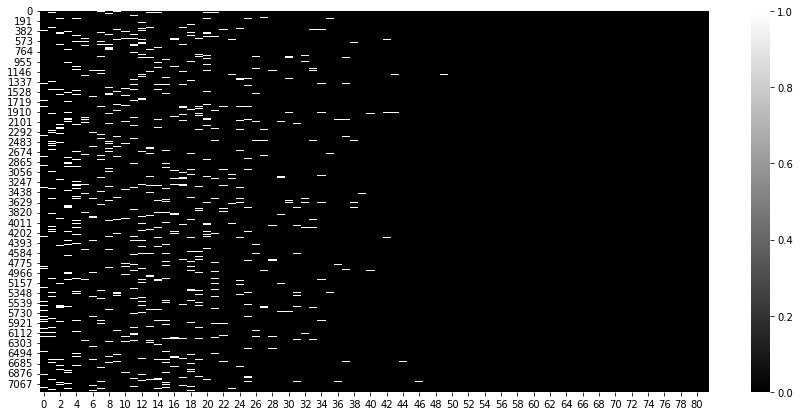

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

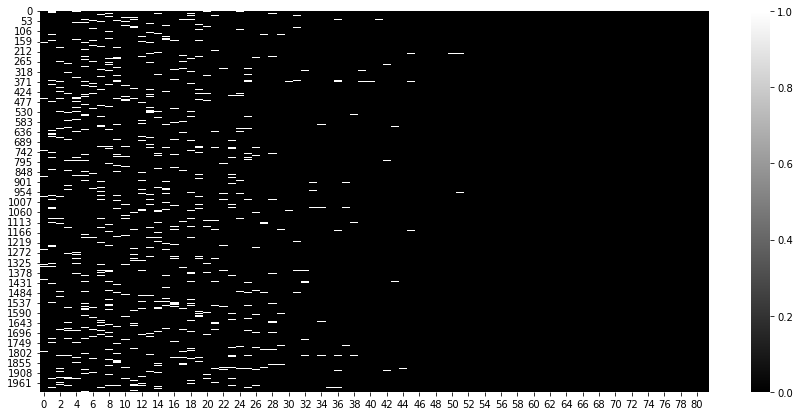

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

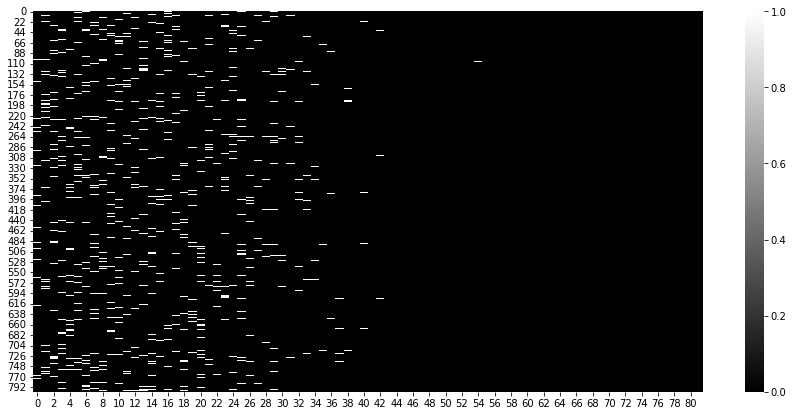

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);